# Llama 3.2 Vision: Independent Single-Turn Bank Statement Extraction

**Protocol**: Three independent single-turn prompts + Python parsing/filtering

**Key Insight**: Multi-turn conversation degrades accuracy. LLM filtering mixes up rows. Use Python for filtering!

---

## Complete Workflow

```
Turn 0: Image + Prompt → Headers (fresh context)
        ↓ (Python pattern matching)
Turn 0.5: Image + Prompt → Date Format Classification (fresh context)
        ↓ (Classification: "Date-per-row" vs "Date-grouped")
Turn 1: Image + Prompt → Full Table (fresh context, format-specific example)
        ↓ (Python parsing + filtering + balance validation)
Schema Fields: TRANSACTION_DATES, LINE_ITEM_DESCRIPTIONS, TRANSACTION_AMOUNTS_PAID
```

### Pipeline Stages:
1. **Turn 0 (LLM)**: Identify column headers from image
2. **Pattern Matching (Python)**: Map headers to concepts (Date, Description, Debit, Credit)
3. **Turn 0.5 (LLM)**: Classify date format ("Date-per-row" vs "Date-grouped")
4. **Turn 1 (LLM)**: Extract full markdown table using **format-specific example**
5. **Balance Validation (Python)**: Auto-correct misalignments using balance mathematics
6. **Python Parsing**: Parse markdown → Filter for debits → Extract schema fields

### Critical Features:
- ✅ **Format Detection** - Auto-detect date-per-row vs date-grouped formats
- ✅ **Format-Specific Examples** - Adapt extraction pattern to detected format
- ✅ **Balance Validation** - Mathematical proof of correct debit/credit alignment
- ✅ **Python filtering** - Reliable debit/credit separation
- ✅ **Dynamic examples** - Adapt to 3/4/5 column formats
- ✅ **Tax accuracy** - Correct Debit/Credit separation critical for identifying purchases

### Date Format Types:
- **Date-per-row** (CBA style): Each transaction row has its own date
- **Date-grouped** (NAB style): Dates as section headers, expanded to each transaction

### Why This Works:
- **Turn 0**: Clean context → accurate header identification
- **Turn 0.5**: Clean context → accurate format classification
- **Turn 1**: Format-specific example → accurate date handling and table extraction
- **Balance Validation**: Mathematical proof → auto-correct misalignments
- **Python**: Reliable Validation/Correction and filtering for debit transactions (what taxpayer PAID)

In [1]:
# Cell 1: Imports
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

# Add parent directory to path AND change working directory for config file resolution
import sys
from pathlib import Path

# Get project root (parent of bank_statement/)
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Change working directory to project root so config/field_definitions.yaml is found
os.chdir(project_root)
print(f"📁 Working directory: {os.getcwd()}")

# Standard library imports
import random

# Third-party imports
import numpy as np
import torch
from PIL import Image
from transformers import AutoProcessor, MllamaForConditionalGeneration
from IPython.display import display, Markdown
from common.reproducibility import set_seed, configure_deterministic_mode
set_seed(42)
configure_deterministic_mode(True) 

📁 Working directory: /home/jovyan/nfs_share/tod/LMM_POC
✅ Random seed set to 42 for reproducibility
✅ PyTorch deterministic mode enabled
⚠️  Note: May reduce performance


# Load the model

In [2]:
# Cell 3: Load Llama-3.2-Vision model
# Update this path to your local Llama model
# model_id = "/home/jovyan/shared_PTM/Llama-3.2-11B-Vision-Instruct"
model_id = "/home/jovyan/nfs_share/models/Llama-3.2-11B-Vision-Instruct"

print("🔧 Loading Llama-3.2-Vision model...")
# model = MllamaForConditionalGeneration.from_pretrained(
#     model_id,
#     torch_dtype=torch.bfloat16,
#     device_map="auto",
# )
# processor = AutoProcessor.from_pretrained(model_id)

from common.llama_model_loader_robust import load_llama_model_robust

model, processor = load_llama_model_robust(
    model_path=model_id,
    use_quantization=False,
    device_map='auto',
    max_new_tokens=2000,
    torch_dtype='bfloat16',
    low_cpu_mem_usage=True,
    verbose=True
)

# Add tie_weights() call
try:
    model.tie_weights()
    print("✅ Model weights tied successfully")
except Exception as e:
    print(f"⚠️ tie_weights() warning: {e}")

# processor

🔧 Loading Llama-3.2-Vision model...


🚀 Loading Llama Vision model with robust multi-GPU optimization...

Features: Smart quantization, memory management, V100 support

🔧 Configuring CUDA memory for Llama...

🔧 CUDA memory allocation configured: max_split_size_mb:64
💡 Using 64MB memory blocks to reduce fragmentation
📊 Initial CUDA state: Allocated=0.00GB, Reserved=0.00GB


🔍 Performing robust GPU memory detection...

🔍 Starting robust GPU memory detection...
📊 Detected 1 GPU(s), analyzing each device...
   GPU 0 (NVIDIA L4): 22.0GB total, 22.0GB available

🔍 ROBUST GPU MEMORY DETECTION REPORT
✅ Success: 1/1 GPUs detected
📊 Total Memory: 21.95GB
💾 Available Memory: 21.95GB
⚡ Allocated Memory: 0.00GB
🔄 Reserved Memory: 0.00GB
📦 Fragmentation: 0.00GB
🖥️  Multi-GPU: No
⚖️  Balanced Distribution: Yes

📋 Per-GPU Breakdown:
   GPU 0 (NVIDIA L4): 22.0GB total, 22.0GB available (0.0% used)


📊 GPU Hardware: NVIDIA L4 (1x 22GB = 22GB total)

🏗️ Architecture: cloud_inference (dynamic detection)

🎯 Model: Llama-3.2-11B-Vision (full precision: 22.0GB, threshold: 24.0GB)

💾 Available Memory: 22.0GB across 1 GPU(s)

💡 Memory sufficient: ❌ No

✅ Cloud inference GPU with 22GB - running in full precision as requested

📊 FINAL QUANTIZATION DECISION: DISABLED (full precision)

   Total GPU Memory: 22GB

   Available Memory: 22GB

Full precision needs: 22.0GB + 2.0GB buffer = 24.0GB threshold

   Working GPUs: 1/1

🚀 Using 16-bit precision for optimal performance

Loading Llama Vision model...

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


Loading processor...

✅ Model and processor loaded successfully!

📊 Single GPU Analysis:

   Device: cuda:0

   GPU: NVIDIA L4

   Memory: 19.79GB allocated, 20.09GB reserved, 24GB total

                            🔧 Llama Vision Model Configuration                            
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Setting             ┃ Value                         ┃ Llama Status                      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Model Path          │ Llama-3.2-11B-Vision-Instruct │ ✅ Valid                          │
│ Device Placement    │ cuda:0                        │ ✅ Loaded                         │
│ Quantization Method │ 16-bit                        │ ✅ 16-bit (Performance Optimized) │
│ Data Type           │ bfloat16                      │ ✅ Recommended                    │
│ Max New Tokens      │ 2000                          │ ✅ Generation Ready               │
│ GPU Configuration   │ 1 GPU(s)                      │ ✅ Available                      │
│ Model Parameters    │ 10,670,220,835                │ ✅ Loaded                         │
│ Memory Optimization │ Llama Robust                  │ ✅ V100 Compatible                │
└─────────────────────┴───────────────────────────────┴───────────────────────────────────┘

Running model compatibility test...

✅ Model compatibility test passed

Performing initial memory cleanup...

🧹 Memory cleanup completed

💾 Final state: Allocated=19.79GB, Reserved=20.09GB, Fragmentation=0.30GB

🎉 Llama Vision model loading and validation complete!

🔧 Llama optimizations active: 16-bit precision, memory management, vision preservation

✅ Model weights tied successfully


# Load the image

📁 Loading image...
✅ Image loaded: (800, 895)
✅ Images list created with 1 image(s)
🖼️  Bank statement image:


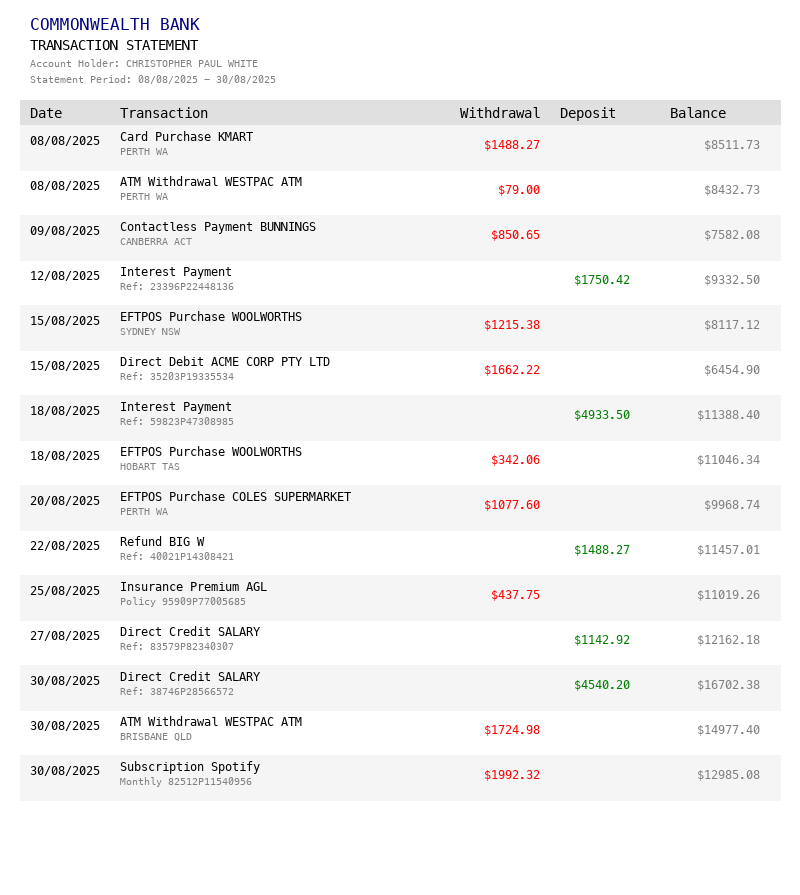

In [3]:
# Cell 5: Load bank statement image
# Update this path to your test image
# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/synthetic_bank_images/cba_amount_balance.png"
# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/synthetic_bank_images/cba_date_grouped_cont.png"
# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/synthetic_bank_images/cba_debit_credit.png"
# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/synthetic_bank_images/cba_highligted.png"
# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/synthetic_bank_images/low_contrast_fixed.png"
# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/synthetic_bank_images/nab_classic_highligted.png"
# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/synthetic_bank_images/westpac_debit_credit.png"
# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/synthetic_bank_images/transaction_summary.png"
# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/cba_date_grouped.png"
# imageName = str(Path.home() / "nfs_share/tod/LMM_POC/evaluation_data/bank/synthetic_chrono.png")
imageName = str(Path.home() / "nfs_share/tod/LMM_POC/evaluation_data/bank/synthetic_multiline.png")

print("📁 Loading image...")
image = Image.open(imageName)

# CRITICAL: Store as list for multi-turn compatibility
images = [image]

print(f"✅ Image loaded: {image.size}")
print(f"✅ Images list created with {len(images)} image(s)")

# Display the loaded image for visual verification
print("🖼️  Bank statement image:")
display(image)

# Bank Statement Extraction Protocol
- Turn 0: Identify actual table headers
- Turn 1: Extract full table using dynamic markdown example
- Python: Parse, filter, and extract schema fields

In [4]:
# Cell 7: Turn 0 - Identify table headers (prompt)
# TURN 0: Identify Table Headers
# First, identify the actual column headers used in this specific bank statement

prompt = """
Look at the transaction table in this bank statement image.

IMPORTANT STRUCTURAL NOTE:
Some bank statements show dates as section headings with multiple transactions underneath.
If you see this structure, remember that each transaction needs its explicit date in the final output.

What are the exact column header names used in the transaction table?

List each column header exactly as it appears, in order from left to right.
Do not interpret or rename them - use the EXACT text from the image.
"""

# Create message structure for Llama
messageDataStructure = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {
                "type": "text",
                "text": prompt,
            },
        ],
    }
]

print("💬 TURN 0: Identifying actual table headers")
print("🤖 Generating response with Llama-3.2-Vision...")

💬 TURN 0: Identifying actual table headers
🤖 Generating response with Llama-3.2-Vision...


# Process the prompt

In [5]:
# Cell 9: Turn 0 - Execute and parse headers
# Process the input using the CORRECT multi-turn pattern
# Based on: https://medium.com/data-science/chat-with-your-images-using-multimodal-llms-60af003e8bfa

textInput = processor.apply_chat_template(
    messageDataStructure, add_generation_prompt=True
)

# CRITICAL: Use named parameter 'images=' with list
inputs = processor(images=images, text=textInput, return_tensors="pt").to(model.device)

# Generate response with deterministic parameters
output = model.generate(
    **inputs,
    max_new_tokens=2000,
    do_sample=False,
    temperature=None,
    top_p=None,
)

# CRITICAL: Trim input tokens from output (this is the key to clean responses!)
generate_ids = output[:, inputs['input_ids'].shape[1]:-1]
cleanedOutput = processor.decode(generate_ids[0], clean_up_tokenization_spaces=False)

print("✅ Response generated successfully!")
print("\n" + "=" * 60)
print("TURN 0 - IDENTIFIED TABLE HEADERS:")
print("=" * 60)
print(cleanedOutput)
print("=" * 60)

# CRITICAL: Parse the identified headers for use in subsequent turns
# Extract column names from the response
header_lines = [line.strip() for line in cleanedOutput.split('\n') if line.strip()]
identified_headers = []

# Look for numbered list or bullet points
for line in header_lines:
    # Remove common list markers
    cleaned = line.lstrip('0123456789.-•* ').strip()
    
    # Strip markdown bold formatting
    cleaned = cleaned.replace('**', '').replace('__', '')
    
    # Skip section headers (lines ending with colon)
    if cleaned.endswith(':'):
        continue
    
    # Skip long sentences (likely explanatory text, not headers)
    if len(cleaned) > 40:
        continue
        
    if cleaned and len(cleaned) > 2:  # Ignore very short strings
        identified_headers.append(cleaned)

print(f"\n📋 Parsed {len(identified_headers)} column headers:")
for i, header in enumerate(identified_headers, 1):
    print(f"  {i}. '{header}'")

# Store headers for use in subsequent turns
table_headers = identified_headers

# Save the table headers
output_path = Path("llama_table_headers.txt")
with output_path.open("w", encoding="utf-8") as text_file:
    text_file.write(cleanedOutput)

print(f"\n✅ Table headers saved to: {output_path}")
print("💡 These LITERAL header names will be used in Turn 1 & 2 prompts")

✅ Response generated successfully!

TURN 0 - IDENTIFIED TABLE HEADERS:
**Transaction Statement Column Headers:**

*   **Date**
*   **Transaction**
*   **Withdrawal**
*   **Deposit**
*   **Balance**

📋 Parsed 5 column headers:
  1. 'Date'
  2. 'Transaction'
  3. 'Withdrawal'
  4. 'Deposit'
  5. 'Balance'

✅ Table headers saved to: llama_table_headers.txt
💡 These LITERAL header names will be used in Turn 1 & 2 prompts


## Turn 0.5: Date Format Classification

Classify whether this statement uses:
- **Date-per-row**: Each transaction row has its own date value
- **Date-grouped**: Dates appear as section headers with multiple transactions underneath

This determines which extraction example to use in Turn 1.

In [6]:
# Cell 11: Turn 0.5 - Classify date format (INDEPENDENT turn)

# Build DYNAMIC classification examples using ACTUAL headers from Turn 0
header_string = " | ".join(table_headers)

def format_example_table(rows, headers):
    """Format example table with proper column alignment."""
    if not rows or not headers:
        return "No data"
    
    # Calculate max width for each column
    num_cols = len(headers)
    col_widths = [len(h) for h in headers]  # Start with header widths
    
    for row in rows:
        for col_idx, val in enumerate(row):
            if col_idx < len(col_widths):
                col_widths[col_idx] = max(col_widths[col_idx], len(str(val)))
    
    # Build formatted table
    formatted = []
    
    # Header row
    header_parts = [headers[i].ljust(col_widths[i]) for i in range(num_cols)]
    formatted.append("  | " + " | ".join(header_parts) + " |")
    
    # Data rows
    for row in rows:
        row_parts = [str(row[i]).ljust(col_widths[i]) for i in range(num_cols)]
        formatted.append("  | " + " | ".join(row_parts) + " |")
    
    return "\n".join(formatted)


# Build example rows for Date-per-row format
date_per_row_rows = []

# Row 1: Debit transaction
row = []
for h in table_headers:
    if h.lower() in ['date', 'day']:
        row.append("15 Jan")
    elif 'desc' in h.lower() or 'particular' in h.lower() or 'detail' in h.lower() or 'transaction' in h.lower():
        row.append("Transaction")
    elif 'debit' in h.lower() or 'withdrawal' in h.lower():
        row.append("50.00")
    elif 'credit' in h.lower() or 'deposit' in h.lower():
        row.append("")
    elif 'balance' in h.lower():
        row.append("$950 CR")
    elif 'amount' in h.lower():
        row.append("50.00")
    else:
        row.append("")
date_per_row_rows.append(row)

# Row 2: Credit transaction (shows in Credit column)
row = []
for h in table_headers:
    if h.lower() in ['date', 'day']:
        row.append("16 Jan")
    elif 'desc' in h.lower() or 'particular' in h.lower() or 'detail' in h.lower() or 'transaction' in h.lower():
        row.append("Transaction")
    elif 'debit' in h.lower() or 'withdrawal' in h.lower():
        row.append("")  # Empty - this is a credit
    elif 'credit' in h.lower() or 'deposit' in h.lower():
        row.append("3,500.00")
    elif 'balance' in h.lower():
        row.append("$4,450 CR")
    elif 'amount' in h.lower():
        row.append("3,500.00")
    else:
        row.append("")
date_per_row_rows.append(row)

# Row 3: Debit transaction (different amount)
row = []
for h in table_headers:
    if h.lower() in ['date', 'day']:
        row.append("17 Jan")
    elif 'desc' in h.lower() or 'particular' in h.lower() or 'detail' in h.lower() or 'transaction' in h.lower():
        row.append("Transaction")
    elif 'debit' in h.lower() or 'withdrawal' in h.lower():
        row.append("150.00")
    elif 'credit' in h.lower() or 'deposit' in h.lower():
        row.append("")
    elif 'balance' in h.lower():
        row.append("$4,300 CR")
    elif 'amount' in h.lower():
        row.append("150.00")
    else:
        row.append("")
date_per_row_rows.append(row)

date_per_row_example = format_example_table(date_per_row_rows, table_headers)

# Build example rows for Date-grouped format
date_grouped_rows = []

# Row 1: Date header (15 Jan)
row = []
for h in table_headers:
    if h.lower() in ['date', 'day']:
        row.append("15 Jan")
    else:
        row.append("")
date_grouped_rows.append(row)

# Row 2: First transaction under 15 Jan
row = []
for h in table_headers:
    if h.lower() in ['date', 'day']:
        row.append("")
    elif 'desc' in h.lower() or 'particular' in h.lower() or 'detail' in h.lower() or 'transaction' in h.lower():
        row.append("Transaction")
    elif 'debit' in h.lower() or 'withdrawal' in h.lower():
        row.append("50.00")
    elif 'credit' in h.lower() or 'deposit' in h.lower():
        row.append("")
    elif 'balance' in h.lower():
        row.append("$950 CR")
    elif 'amount' in h.lower():
        row.append("50.00")
    else:
        row.append("")
date_grouped_rows.append(row)

# Row 3: Second transaction under 15 Jan (balance continues to decrease)
row = []
for h in table_headers:
    if h.lower() in ['date', 'day']:
        row.append("")
    elif 'desc' in h.lower() or 'particular' in h.lower() or 'detail' in h.lower() or 'transaction' in h.lower():
        row.append("Transaction")
    elif 'debit' in h.lower() or 'withdrawal' in h.lower():
        row.append("75.00")
    elif 'credit' in h.lower() or 'deposit' in h.lower():
        row.append("")
    elif 'balance' in h.lower():
        row.append("$875 CR")
    elif 'amount' in h.lower():
        row.append("75.00")
    else:
        row.append("")
date_grouped_rows.append(row)

# Row 4: Date header (16 Jan)
row = []
for h in table_headers:
    if h.lower() in ['date', 'day']:
        row.append("16 Jan")
    else:
        row.append("")
date_grouped_rows.append(row)

# Row 5: Transaction under 16 Jan (credit increases balance)
row = []
for h in table_headers:
    if h.lower() in ['date', 'day']:
        row.append("")
    elif 'desc' in h.lower() or 'particular' in h.lower() or 'detail' in h.lower() or 'transaction' in h.lower():
        row.append("Transaction")
    elif 'debit' in h.lower() or 'withdrawal' in h.lower():
        row.append("")
    elif 'credit' in h.lower() or 'deposit' in h.lower():
        row.append("200.00")
    elif 'balance' in h.lower():
        row.append("$1,075 CR")
    elif 'amount' in h.lower():
        row.append("200.00")
    else:
        row.append("")
date_grouped_rows.append(row)

date_grouped_example = format_example_table(date_grouped_rows, table_headers)

# Build classification prompt with YAML header + DYNAMIC examples
format_classification_prompt = f"""Analyze this bank statement image and classify its structural layout.

Look at how transactions are organized:

Date-per-row: Transactions are in a continuous table format with column headers
- Each transaction row starts with a date value

Example of Date-per-row structure:
{date_per_row_example}

Date-grouped: Transactions are grouped under date section headers
- Have date headers that collect transactions by date
- Transaction Rows are listed WITHOUT individual date values
- Each transaction row does NOT start with its own date value

Example of Date-grouped structure:
{date_grouped_example}

Does each transaction have its own date value, or are the transactions grouped by date?

If each transaction has its own individual date in a table: Respond with "Date-per-row"
If transactions are grouped under shared date headers: Respond with "Date-grouped"

Response:"""

print("\n" + "=" * 60)
print("CLASSIFICATION PROMPT:")
print("=" * 60)
print(format_classification_prompt)
print("=" * 60 + "\n")

# CRITICAL: Create FRESH message structure (independent turn)
messageDataStructure_format = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": format_classification_prompt}
        ]
    }
]

print("💬 TURN 0.5: Classifying date format")
print("🤖 Generating response with Llama-3.2-Vision...")

# Process with FRESH context
textInput = processor.apply_chat_template(
    messageDataStructure_format, add_generation_prompt=True
)

inputs = processor(images=images, text=textInput, return_tensors="pt").to(model.device)

output = model.generate(
    **inputs,
    max_new_tokens=100,
    do_sample=False,
    temperature=None,
    top_p=None,
)

generate_ids = output[:, inputs['input_ids'].shape[1]:-1]
format_response = processor.decode(generate_ids[0], clean_up_tokenization_spaces=False).strip()

print("✅ Response generated successfully!")
print("\n" + "=" * 60)
print("TURN 0.5 - DATE FORMAT CLASSIFICATION:")
print("=" * 60)
print(format_response)
print("=" * 60)

# Parse classification
date_format = "Date-per-row"
if "Date-grouped" in format_response or "date-grouped" in format_response:
    date_format = "Date-grouped"
elif "Date-per-row" in format_response or "date-per-row" in format_response:
    date_format = "Date-per-row"

print(f"\n📊 Detected Format: {date_format}")

# Save classification result
output_path = Path("llama_date_format_classification.txt")
with output_path.open("w", encoding="utf-8") as f:
    f.write(f"Classification: {date_format}\n")
    f.write(f"Raw response: {format_response}\n")

print(f"✅ Classification saved to: {output_path}")
print(f"💡 This format will determine the Turn 1 extraction example")


CLASSIFICATION PROMPT:
Analyze this bank statement image and classify its structural layout.

Look at how transactions are organized:

Date-per-row: Transactions are in a continuous table format with column headers
- Each transaction row starts with a date value

Example of Date-per-row structure:
  | Date   | Transaction | Withdrawal | Deposit  | Balance   |
  | 15 Jan | Transaction | 50.00      |          | $950 CR   |
  | 16 Jan | Transaction |            | 3,500.00 | $4,450 CR |
  | 17 Jan | Transaction | 150.00     |          | $4,300 CR |

Date-grouped: Transactions are grouped under date section headers
- Have date headers that collect transactions by date
- Transaction Rows are listed WITHOUT individual date values
- Each transaction row does NOT start with its own date value

Example of Date-grouped structure:
  | Date   | Transaction | Withdrawal | Deposit | Balance   |
  | 15 Jan |             |            |         |           |
  |        | Transaction | 50.00      |     

## Pattern Matching: Map Generic Concepts to Actual Headers

Different bank statements use different column names. Use pattern matching to identify:
- Which header represents **Date**
- Which header represents **Description/Details**  
- Which header represents **Debit/Withdrawal**

In [7]:
# Cell 13: Pattern Matching - Map headers to generic columns
# Pattern Matching: Map extracted headers to generic concepts
# This handles variety in bank statement column naming conventions

# Pattern keywords for each concept (in priority order)
DATE_PATTERNS = ['date', 'day', 'transaction date', 'trans date']
DESCRIPTION_PATTERNS = [
    'description', 'details', 'transaction details', 'trans details',
    'particulars', 'narrative', 'transaction', 'trans'
]
DEBIT_PATTERNS = ['debit', 'withdrawal', 'withdrawals', 'paid', 'paid out', 'spent', 'dr']
CREDIT_PATTERNS = ['credit', 'deposit', 'deposits', 'received', 'cr']
BALANCE_PATTERNS = ['balance', 'bal', 'running balance']

# NEW: Pattern for single-column transaction formats (e.g., "Amount" instead of separate Debit/Credit)
AMOUNT_PATTERNS = ['amount', 'amt', 'value', 'total']

def match_header(headers, patterns, fallback=None):
    """Match a header using pattern keywords.
    
    Matching strategy:
    1. Exact match (case-insensitive)
    2. Substring match (only for patterns with length > 2 to avoid false positives)
    """
    headers_lower = [h.lower() for h in headers]
    
    # Try exact match first
    for pattern in patterns:
        for i, header_lower in enumerate(headers_lower):
            if pattern == header_lower:
                return headers[i]
    
    # Try substring match (only for patterns longer than 2 chars)
    for pattern in patterns:
        if len(pattern) > 2:  # Avoid false positives like 'cr' matching 'description'
            for i, header_lower in enumerate(headers_lower):
                if pattern in header_lower:
                    return headers[i]
    
    return fallback

# Perform pattern matching on extracted headers
date_col = match_header(table_headers, DATE_PATTERNS, fallback=table_headers[0] if table_headers else 'Date')
desc_col = match_header(table_headers, DESCRIPTION_PATTERNS, fallback=table_headers[1] if len(table_headers) > 1 else 'Description')

# NEW: First try to match a generic "Amount" column (for 4-column formats)
amount_col = match_header(table_headers, AMOUNT_PATTERNS, fallback=None)

# Use amount_col as fallback if no separate debit/credit columns exist
# This handles formats like: Date | Description | Amount | Balance
debit_col = match_header(table_headers, DEBIT_PATTERNS, fallback=amount_col if amount_col else 'Debit')
credit_col = match_header(table_headers, CREDIT_PATTERNS, fallback=amount_col if amount_col else 'Credit')
balance_col = match_header(table_headers, BALANCE_PATTERNS, fallback='Balance')

print("=" * 60)
print("PATTERN MATCHING RESULTS:")
print("=" * 60)
print(f"📋 Extracted Headers: {table_headers}")
print(f"\n🔍 Mapped Columns:")
print(f"  Date        → '{date_col}'")
print(f"  Description → '{desc_col}'")
print(f"  Debit       → '{debit_col}'")
print(f"  Credit      → '{credit_col}'")
print(f"  Balance     → '{balance_col}'")
if amount_col:
    print(f"\n💡 Single-column format detected: '{amount_col}' used for both debit and credit")
print("=" * 60)
print("\n✅ These literal column names will be used in Turn 1 and Turn 2")
print("💡 Adjust patterns above if matching fails for your bank statement format")

PATTERN MATCHING RESULTS:
📋 Extracted Headers: ['Date', 'Transaction', 'Withdrawal', 'Deposit', 'Balance']

🔍 Mapped Columns:
  Date        → 'Date'
  Description → 'Transaction'
  Debit       → 'Withdrawal'
  Credit      → 'Deposit'
  Balance     → 'Balance'

✅ These literal column names will be used in Turn 1 and Turn 2
💡 Adjust patterns above if matching fails for your bank statement format


### 🔑 Independent Single-Turn Pattern (NOT Multi-Turn Conversation)

**CRITICAL INSIGHT**: Multi-turn conversation accumulates context and degrades accuracy.

We use **two independent single-turn prompts**, each with fresh context:

#### Key Principles:

1. **No Conversation History**: Each turn is completely independent
2. **Fresh Image Attention**: Each turn processes the image directly
3. **No Context Accumulation**: Prevents attention dilution
4. **Headers as Parameters**: Turn 0 headers used to generate dynamic examples for Turn 1
5. **Python Filtering**: LLM filtering mixes up rows - Python is reliable

#### Message Structure for Each Turn:

Every turn uses fresh structure:
```python
messageDataStructure = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "<prompt with dynamic example>"}
        ]
    }
]
```

**No assistant responses in history. No conversation accumulation.**

#### Why This Works Better:

- **Turn 0**: Clean context → accurate header identification
- **Turn 1**: Clean context + dynamic example → accurate table extraction  
- **Python**: Reliable parsing and filtering (no row mixing!)

Each turn has **full attention** on the image, not diluted by conversation history.

In [8]:
# Cell 15: NO conversation history (independent turns)
# 
# CRITICAL: We do NOT use conversation history in this notebook.
# Each turn is completely independent with fresh context.
#
# Why? Multi-turn conversation accumulates context and degrades accuracy:
# - Turn 0: ~50 tokens → accurate
# - Turn 1 with history: ~350 tokens → attention diluted → less accurate
# - Turn 2 with history: ~2000 tokens → attention heavily diluted → row mixing!
#
# Instead: 
# - Turn 0: Fresh context → headers
# - Turn 1: Fresh context + dynamic example → full table
# - Python: Parse and filter (no LLM confusion!)

print("✅ Independent turn approach - NO conversation history")
print("💡 Each turn has fresh context with direct image access")
print("🐍 Python handles all filtering - no LLM row mixing!")

✅ Independent turn approach - NO conversation history
💡 Each turn has fresh context with direct image access
🐍 Python handles all filtering - no LLM row mixing!


## Generate Column Aware Extraction Prompt

In [9]:
# Cell 17: Generate Minimal Extraction Prompt (Format-Specific)

def format_aligned_table(rows_data, headers):
    """Format table with aligned vertical pipes (for date-grouped transformation clarity)."""
    if not rows_data or not headers:
        return "No data"
    
    # Calculate max width for each column
    num_cols = len(headers)
    col_widths = [len(h) for h in headers]
    
    for row in rows_data:
        for col_idx, val in enumerate(row):
            if col_idx < num_cols:
                col_widths[col_idx] = max(col_widths[col_idx], len(str(val)))
    
    # Build formatted table
    formatted = []
    
    # Header row
    header_parts = [headers[i].ljust(col_widths[i]) for i in range(num_cols)]
    formatted.append("| " + " | ".join(header_parts) + " |")
    
    # Data rows
    for row in rows_data:
        row_parts = [str(row[i]).ljust(col_widths[i]) for i in range(num_cols)]
        formatted.append("| " + " | ".join(row_parts) + " |")
    
    return "\n".join(formatted)

def build_minimal_date_per_row_extraction(headers):
    """Minimal extraction example for date-per-row format."""
    rows = []
    
    for date, desc, deb, cred, bal in [
        ("15 Jan", "ATM Withdrawal", "200.00", "", "$1,500.00 CR"),
        ("16 Jan", "Salary Payment", "", "3,500.00", "$5,000.00 CR"),
        ("17 Jan", "Online Purchase", "150.00", "", "$4,850.00 CR")
    ]:
        row = []
        for h in headers:
            if h.lower() in ['date', 'day']:
                row.append(date)
            elif 'desc' in h.lower() or 'particular' in h.lower() or 'detail' in h.lower() or 'transaction' in h.lower():
                row.append(desc)
            elif 'debit' in h.lower() or 'withdrawal' in h.lower():
                row.append(deb)
            elif 'credit' in h.lower() or 'deposit' in h.lower():
                row.append(cred)
            elif 'balance' in h.lower():
                row.append(bal)
            elif 'amount' in h.lower():
                row.append(deb if deb else cred)
            else:
                row.append("")
        rows.append("| " + " | ".join(row) + " |")
    
    return rows

def build_date_grouped_source(headers):
    """Show how date-grouped appears in the image (with empty date cells)."""
    rows = []
    
    # Date header row with empty cells
    for date, desc, deb, cred, bal in [
        ("22 Mar", "", "", "", ""),
        ("", "Auto Services", "580.00", "", "$8,721.15 CR"),
        ("", "EFTPOS Grocers", "125.00", "", "$8,596.15 CR"),
        ("23 Mar", "", "", "", ""),
        ("", "VISA Markets", "89.75", "", "$8,506.40 CR")
    ]:
        row = []
        for h in headers:
            if h.lower() in ['date', 'day']:
                row.append(date)
            elif 'desc' in h.lower() or 'particular' in h.lower() or 'detail' in h.lower() or 'transaction' in h.lower():
                row.append(desc)
            elif 'debit' in h.lower() or 'withdrawal' in h.lower():
                row.append(deb)
            elif 'credit' in h.lower() or 'deposit' in h.lower():
                row.append(cred)
            elif 'balance' in h.lower():
                row.append(bal)
            elif 'amount' in h.lower():
                row.append(deb if deb else cred)
            else:
                row.append("")
        rows.append(row)
    
    return rows

def build_date_grouped_target(headers):
    """Show how to extract date-grouped (with dates distributed)."""
    rows = []
    
    for date, desc, deb, cred, bal in [
        ("22 Mar", "Auto Services", "580.00", "", "$8,721.15 CR"),
        ("22 Mar", "EFTPOS Grocers", "125.00", "", "$8,596.15 CR"),
        ("23 Mar", "VISA Markets", "89.75", "", "$8,506.40 CR")
    ]:
        row = []
        for h in headers:
            if h.lower() in ['date', 'day']:
                row.append(date)
            elif 'desc' in h.lower() or 'particular' in h.lower() or 'detail' in h.lower() or 'transaction' in h.lower():
                row.append(desc)
            elif 'debit' in h.lower() or 'withdrawal' in h.lower():
                row.append(deb)
            elif 'credit' in h.lower() or 'deposit' in h.lower():
                row.append(cred)
            elif 'balance' in h.lower():
                row.append(bal)
            elif 'amount' in h.lower():
                row.append(deb if deb else cred)
            else:
                row.append("")
        rows.append(row)
    
    return rows

# Generate format-specific example
print(f"🎯 Building extraction prompt for format: {date_format}")

if date_format == "Date-grouped":
    # Use aligned formatting for transformation clarity
    source_rows = build_date_grouped_source(table_headers)
    target_rows = build_date_grouped_target(table_headers)
    source_table = format_aligned_table(source_rows, table_headers)
    target_table = format_aligned_table(target_rows, table_headers)
    
    follow_up_prompt = f"""Extract the transaction table as markdown.

If you see this structure (dates as section headers with empty cells):
{source_table}

Extract as (distribute date to every transaction row):
{target_table}

Output: Markdown table only."""

else:
    # Minimal formatting for date-per-row
    example_rows = build_minimal_date_per_row_extraction(table_headers)
    header_row = "| " + " | ".join(table_headers) + " |"
    example_table = header_row + "\n" + "\n".join(example_rows)
    
    follow_up_prompt = f"""Extract the transaction table as markdown.

Example format:
{example_table}

Extract ALL transactions.

Output: Markdown table only."""

print("\n" + "=" * 60)
print(f"Turn 1 Extraction Prompt ({date_format} format):")
print("=" * 60)
print(f"\n{follow_up_prompt}")
print("=" * 60 + "\n")


🎯 Building extraction prompt for format: Date-per-row

Turn 1 Extraction Prompt (Date-per-row format):

Extract the transaction table as markdown.

Example format:
| Date | Transaction | Withdrawal | Deposit | Balance |
| 15 Jan | ATM Withdrawal | 200.00 |  | $1,500.00 CR |
| 16 Jan | Salary Payment |  | 3,500.00 | $5,000.00 CR |
| 17 Jan | Online Purchase | 150.00 |  | $4,850.00 CR |

Extract ALL transactions.

Output: Markdown table only.



### TURN 1: Extract Full Table in Markdown

Now that we know the actual column headers, extract the complete table:

In [10]:
# Cell 19: Turn 1 - Extract full table (INDEPENDENT, fresh context)

# # CRITICAL: Create FRESH message structure (NOT appending to conversation history)
messageDataStructure_turn1 = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": follow_up_prompt}
        ]
    }
]

print("Generating response with Llama-3.2-Vision...")

# Process with FRESH context
textInput = processor.apply_chat_template(
    messageDataStructure_turn1, add_generation_prompt=True
)

# CRITICAL: Use named parameter 'images=' with list
inputs = processor(images=images, text=textInput, return_tensors="pt").to(model.device)

# Generate response
output = model.generate(
    **inputs,
    max_new_tokens=2000,
    do_sample=False,
    temperature=None,
    top_p=None,
)

# CRITICAL: Trim input tokens from output
generate_ids = output[:, inputs['input_ids'].shape[1]:-1]
cleanedOutput2 = processor.decode(generate_ids[0], clean_up_tokenization_spaces=False)

print("\nTurn 1 extraction complete!")

# Display the extracted table as rendered HTML for reliable visual verification
# NOTE: display(Markdown(...)) has rendering issues with empty cells - use HTML instead
print("\n" + "=" * 60)
print("TURN 1 - EXTRACTED MARKDOWN TABLE (Rendered as HTML):")
print("=" * 60)

def markdown_table_to_html(markdown_text):
    """Convert markdown table to HTML for reliable Jupyter rendering."""
    lines = [line.strip() for line in markdown_text.strip().split('\n') if line.strip()]
    
    html_parts = ['<table border="1" style="border-collapse: collapse;">']
    is_header = True
    
    for line in lines:
        if '|' not in line:
            continue
        
        # Skip separator rows
        cleaned = line.replace('|', '').replace('-', '').replace(' ', '').replace(':', '')
        if not cleaned:
            continue
        
        # Parse cells
        cells = [c.strip() for c in line.split('|')]
        # Remove empty leading/trailing from pipe delimiters
        if cells and cells[0] == '':
            cells = cells[1:]
        if cells and cells[-1] == '':
            cells = cells[:-1]
        
        if is_header:
            html_parts.append('<tr style="background-color: #f0f0f0;">')
            for cell in cells:
                html_parts.append(f'<th style="padding: 8px; text-align: left;">{cell}</th>')
            html_parts.append('</tr>')
            is_header = False
        else:
            html_parts.append('<tr>')
            for cell in cells:
                html_parts.append(f'<td style="padding: 8px;">{cell if cell else "&nbsp;"}</td>')
            html_parts.append('</tr>')
    
    html_parts.append('</table>')
    return '\n'.join(html_parts)

# Render as HTML table (more reliable than Markdown for tables with empty cells)
from IPython.display import HTML
html_table = markdown_table_to_html(cleanedOutput2)
display(HTML(html_table))

# Comment out the problematic Markdown display - it corrupts tables with empty cells
# display(Markdown(cleanedOutput2))

print("\n" + "=" * 60)
print("TURN 1 - RAW MARKDOWN TEXT:")
print("=" * 60)
print(cleanedOutput2)
print("=" * 60)

# Save the markdown table
output_path = Path("llama_markdown_table_extraction.txt")
with output_path.open("w", encoding="utf-8") as text_file:
    text_file.write(cleanedOutput2)

print(f"\nMarkdown table saved to: {output_path}")

Generating response with Llama-3.2-Vision...

Turn 1 extraction complete!

TURN 1 - EXTRACTED MARKDOWN TABLE (Rendered as HTML):


Date,Transaction,Withdrawal,Deposit,Balance
08/08/2025,Card Purchase KMART,$1488.27,,$8511.73
08/08/2025,ATM Withdrawal WESTPAC ATM,$79.00,,$8432.73
09/08/2025,Contactless Payment BUNNINGS,$850.65,,$7582.08
12/08/2025,Interest Payment,,$1750.42,$9332.50
15/08/2025,EFTPOS Purchase WOOLWORTHS,$1215.38,,$8117.12
15/08/2025,Direct Debit ACME CORP PTY LTD,,$1662.22,$6454.90
18/08/2025,Interest Payment,,$4933.50,$11388.40
18/08/2025,EFTPOS Purchase WOOLWORTHS,$342.06,,$11046.34
20/08/2025,EFTPOS Purchase COLES SUPERMARKET,$1077.60,,$9968.74
22/08/2025,Refund BIG W,,$1488.27,$11457.01



TURN 1 - RAW MARKDOWN TEXT:
| Date | Transaction | Withdrawal | Deposit | Balance |
| --- | --- | --- | --- | --- |
| 08/08/2025 | Card Purchase KMART | $1488.27 |  | $8511.73 |
| 08/08/2025 | ATM Withdrawal WESTPAC ATM | $79.00 |  | $8432.73 |
| 09/08/2025 | Contactless Payment BUNNINGS | $850.65 |  | $7582.08 |
| 12/08/2025 | Interest Payment |  | $1750.42 | $9332.50 |
| 15/08/2025 | EFTPOS Purchase WOOLWORTHS | $1215.38 |  | $8117.12 |
| 15/08/2025 | Direct Debit ACME CORP PTY LTD |  | $1662.22 | $6454.90 |
| 18/08/2025 | Interest Payment |  | $4933.50 | $11388.40 |
| 18/08/2025 | EFTPOS Purchase WOOLWORTHS | $342.06 |  | $11046.34 |
| 20/08/2025 | EFTPOS Purchase COLES SUPERMARKET | $1077.60 |  | $9968.74 |
| 22/08/2025 | Refund BIG W |  | $1488.27 | $11457.01 |
| 25/08/2025 | Insurance Premium AGL |  | $437.75 | $11019.26 |
| 27/08/2025 | Direct Credit SALARY |  | $1142.92 | $12162.18 |
| 30/08/2025 | Direct Credit SALARY |  | $4540.20 | $16702.38 |
| 30/08/2025 | ATM Withdrawal 

## Balance-Based Validation/Correction
- Validate that total debits + total credits = balance change
- Ensures accurate debit/credit separation

In [11]:
# Cell: Balance-Based Debit/Credit Validation Function
# CRITICAL: Rows must be sorted by date for balance validation to work correctly
# BUT: Returns rows in ORIGINAL order to match ground truth for evaluation

from dateutil import parser as date_parser


def sort_rows_by_date(rows, date_col):
    """
    Sort rows by date in chronological order (oldest first).
    
    This is CRITICAL because LLM extraction often returns rows in scrambled order.
    Balance validation requires sequential date order to work correctly.
    
    Args:
        rows: List of dictionaries (parsed markdown table rows)
        date_col: Name of the Date column
    
    Returns:
        Tuple of (sorted_rows, original_indices, was_reordered) where:
        - sorted_rows: Rows sorted by date
        - original_indices: List mapping sorted position -> original position
        - was_reordered: True if sorting changed the order
    """
    if not rows or date_col not in rows[0]:
        print(f"⚠️  Date column '{date_col}' not found - cannot sort")
        return rows, list(range(len(rows))), False
    
    def parse_date(date_str):
        """Parse date string to datetime for sorting."""
        if not date_str or not date_str.strip():
            return None
        try:
            # Use dayfirst=True for Australian date format (DD/MM/YYYY)
            return date_parser.parse(date_str.strip(), dayfirst=True)
        except (ValueError, TypeError):
            return None
    
    # Create list of (parsed_date, original_index, row) for sorting
    dated_rows = []
    for i, row in enumerate(rows):
        parsed = parse_date(row.get(date_col, ""))
        dated_rows.append((parsed, i, row))
    
    # Check if any dates failed to parse
    failed_parses = sum(1 for d, _, _ in dated_rows if d is None)
    if failed_parses > len(rows) * 0.5:
        print(f"⚠️  Too many date parse failures ({failed_parses}/{len(rows)}) - cannot sort reliably")
        return rows, list(range(len(rows))), False
    
    # Sort by date (None dates go to end)
    sorted_dated = sorted(dated_rows, key=lambda x: (x[0] is None, x[0]))
    
    # Extract sorted rows and original indices
    sorted_rows = [row for _, _, row in sorted_dated]
    original_indices = [orig_idx for _, orig_idx, _ in sorted_dated]
    
    # Check if order changed
    was_reordered = original_indices != list(range(len(rows)))
    
    return sorted_rows, original_indices, was_reordered


def detect_document_order(rows, balance_col):
    """
    Detect if document is in chronological or reverse chronological order.
    
    Logic: If balances generally INCREASE going down the table, the document
    is in reverse chronological order (newest first, oldest last).
    
    Returns:
        str: "chronological" or "reverse_chronological"
    """
    def parse_amount(value):
        if not value or value.strip() == "":
            return 0.0
        cleaned = value.replace("$", "").replace(",", "").replace("CR", "").replace("DR", "").strip()
        try:
            return float(cleaned)
        except ValueError:
            return 0.0
    
    if len(rows) < 3:
        return "chronological"  # Default assumption
    
    # Sample multiple balance transitions to determine trend
    increases = 0
    decreases = 0
    
    for i in range(1, min(len(rows), 10)):  # Check first 10 rows
        prev_balance = parse_amount(rows[i-1].get(balance_col, "0"))
        curr_balance = parse_amount(rows[i].get(balance_col, "0"))
        
        if curr_balance > prev_balance + 0.01:
            increases += 1
        elif curr_balance < prev_balance - 0.01:
            decreases += 1
    
    # If balances mostly increase going down → reverse chronological
    if increases > decreases:
        return "reverse_chronological"
    else:
        return "chronological"


def validate_and_correct_alignment(rows, balance_col, debit_col, credit_col, desc_col, date_col="Date"):
    """
    Use balance changes to validate and correct debit/credit alignment.
    
    CRITICAL: This function SORTS rows by date for validation, but RETURNS
    rows in their ORIGINAL order to preserve ground truth alignment for evaluation.
    
    Process:
    1. Sort rows by date (for accurate balance validation)
    2. Validate and correct using sorted order
    3. Map corrections back to original row positions
    4. Return rows in ORIGINAL order with corrections applied
    
    Args:
        rows: List of dictionaries (parsed markdown table rows)
        balance_col: Name of the Balance column
        debit_col: Name of the Debit column
        credit_col: Name of the Credit column
        desc_col: Name of the Description column (to detect opening/closing balance)
        date_col: Name of the Date column (for sorting)
    
    Returns:
        List of corrected row dictionaries (in ORIGINAL order, not sorted)
    """
    
    def parse_amount(value):
        """Extract numeric value from formatted currency string."""
        if not value or value.strip() == "":
            return 0.0
        # Remove currency symbols, commas, CR/DR markers
        cleaned = value.replace("$", "").replace(",", "").replace("CR", "").replace("DR", "").strip()
        try:
            return float(cleaned)
        except ValueError:
            return 0.0
    
    def is_balance_row(row, desc_col):
        """Check if this row is an opening/closing balance row (not a transaction)."""
        desc = row.get(desc_col, "").upper()
        return "OPENING BALANCE" in desc or "CLOSING BALANCE" in desc
    
    # Check if Balance column exists
    if not rows or balance_col not in rows[0]:
        print(f"⚠️  Balance column '{balance_col}' not found - skipping validation")
        return rows
    
    # CRITICAL: Sort rows by date FIRST for accurate validation
    print("📅 Sorting rows by date for accurate balance validation...")
    sorted_rows, original_indices, was_reordered = sort_rows_by_date(rows, date_col)
    
    if was_reordered:
        print("✅ Rows were reordered by date (LLM extraction was not in date order)")
    else:
        print("✅ Rows were already in date order")
    
    # After sorting, detect document order on the sorted rows
    doc_order = detect_document_order(sorted_rows, balance_col)
    print(f"📊 Document order detected (after sort): {doc_order.upper()}")
    
    if doc_order == "reverse_chronological":
        print("💡 Reverse chronological detected even after date sorting")
        print("💡 Validation logic inverted: balance increase → DEBIT, balance decrease → CREDIT")
    
    # Create a copy of original rows for correction (preserves original order)
    corrected_rows = [row.copy() for row in rows]
    corrections_made = 0
    
    # Build reverse mapping: original_index -> sorted_index
    sorted_to_original = {sorted_idx: orig_idx for sorted_idx, orig_idx in enumerate(original_indices)}
    
    # Track which sorted indices are balance rows (to skip)
    balance_row_indices = set()
    for sorted_idx, row in enumerate(sorted_rows):
        if is_balance_row(row, desc_col):
            balance_row_indices.add(sorted_idx)
    
    # Validate using SORTED order, apply corrections to ORIGINAL positions
    start_idx = 0
    
    # Check if row 0 (in sorted order) is an opening balance row
    if sorted_rows and is_balance_row(sorted_rows[0], desc_col):
        print(f"✅ Sorted row 0: Opening/closing balance detected - skipping (not a transaction)")
        start_idx = 1
    elif sorted_rows:
        print(f"✅ Sorted row 0: First transaction included without validation (no previous balance to compare)")
        start_idx = 1
    
    # Validate remaining rows using sorted order
    for sorted_idx in range(start_idx, len(sorted_rows)):
        current_row = sorted_rows[sorted_idx]
        original_idx = original_indices[sorted_idx]
        
        # Skip balance rows
        if sorted_idx in balance_row_indices:
            print(f"⚠️  Sorted row {sorted_idx}: Opening/closing balance row detected - skipping")
            continue
        
        # Find previous non-balance row in sorted order
        prev_sorted_idx = sorted_idx - 1
        while prev_sorted_idx >= 0 and prev_sorted_idx in balance_row_indices:
            prev_sorted_idx -= 1
        
        if prev_sorted_idx < 0:
            print(f"✅ Sorted row {sorted_idx}: First transaction after balance row - included without validation")
            continue
        
        # Parse balances from sorted rows
        prev_balance = parse_amount(sorted_rows[prev_sorted_idx].get(balance_col, "0"))
        curr_balance = parse_amount(current_row.get(balance_col, "0"))
        
        # Calculate balance change
        balance_change = curr_balance - prev_balance
        
        # Parse current debit/credit values
        debit_value = parse_amount(current_row.get(debit_col, ""))
        credit_value = parse_amount(current_row.get(credit_col, ""))
        
        # Determine if correction needed and apply to ORIGINAL position
        correction_needed = False
        swap_to_debit = False  # True = move from Credit to Debit, False = move from Debit to Credit
        
        if doc_order == "reverse_chronological":
            if balance_change > 0.01 and credit_value > 0 and debit_value == 0:
                correction_needed = True
                swap_to_debit = True
                print(f"⚠️  Row {original_idx} (sorted {sorted_idx}): Balance increased by ${balance_change:.2f} → moving ${credit_value:.2f} Credit → Debit")
            elif balance_change < -0.01 and debit_value > 0 and credit_value == 0:
                correction_needed = True
                swap_to_debit = False
                print(f"⚠️  Row {original_idx} (sorted {sorted_idx}): Balance decreased by ${abs(balance_change):.2f} → moving ${debit_value:.2f} Debit → Credit")
        else:
            if balance_change > 0.01 and debit_value > 0 and credit_value == 0:
                correction_needed = True
                swap_to_debit = False
                print(f"⚠️  Row {original_idx} (sorted {sorted_idx}): Balance increased by ${balance_change:.2f} → moving ${debit_value:.2f} Debit → Credit")
            elif balance_change < -0.01 and credit_value > 0 and debit_value == 0:
                correction_needed = True
                swap_to_debit = True
                print(f"⚠️  Row {original_idx} (sorted {sorted_idx}): Balance decreased by ${abs(balance_change):.2f} → moving ${credit_value:.2f} Credit → Debit")
        
        # Apply correction to the ORIGINAL position
        if correction_needed:
            if swap_to_debit:
                corrected_rows[original_idx][debit_col] = corrected_rows[original_idx][credit_col]
                corrected_rows[original_idx][credit_col] = ""
            else:
                corrected_rows[original_idx][credit_col] = corrected_rows[original_idx][debit_col]
                corrected_rows[original_idx][debit_col] = ""
            corrections_made += 1
    
    print(f"\n✅ Balance validation complete: {corrections_made} corrections made")
    print(f"✅ Total rows processed: {len(rows)} (returned in ORIGINAL order)")
    return corrected_rows

print("✅ Balance validation function defined")
print("💡 CRITICAL: Rows are SORTED BY DATE for validation accuracy")
print("💡 CRITICAL: Rows are RETURNED IN ORIGINAL ORDER for ground truth evaluation")
print("💡 Opening/closing balance rows are automatically detected and skipped")

✅ Balance validation function defined
💡 CRITICAL: Rows are SORTED BY DATE for validation accuracy
💡 CRITICAL: Rows are RETURNED IN ORIGINAL ORDER for ground truth evaluation
💡 Opening/closing balance rows are automatically detected and skipped


## Python Parsing and Filtering

Parse the Turn 1 markdown table, filter for debit transactions, and extract schema fields using Python.

In [12]:
from dateutil import parser as date_parser


def _compute_date_range(dates: list[str]) -> str:
    """
    Compute statement date range ensuring chronological order (oldest - newest).
    
    Bank statements may be in reverse chronological order (newest first),
    so we parse and sort dates to ensure correct order.
    """
    if not dates:
        return "NOT_FOUND"
    
    parsed_dates = []
    for date_str in dates:
        if not date_str or not date_str.strip():
            continue
        try:
            parsed = date_parser.parse(date_str.strip(), dayfirst=True)
            parsed_dates.append((parsed, date_str.strip()))
        except (ValueError, TypeError):
            continue
    
    if not parsed_dates:
        return f"{dates[0]} - {dates[-1]}" if len(dates) >= 2 else dates[0]
    
    parsed_dates.sort(key=lambda x: x[0])
    oldest = parsed_dates[0][1]
    newest = parsed_dates[-1][1]
    
    return f"{oldest} - {newest}"


# Cell 23: Parse Turn 1 markdown table and filter for debits (Python)
import re
from datetime import datetime
from IPython.display import HTML

def parse_markdown_table(markdown_text):
    """Parse markdown table into list of dictionaries.
    
    CRITICAL: Must preserve empty columns for correct Debit/Credit alignment!
    """
    lines = [line.strip() for line in markdown_text.strip().split('\n') if line.strip()]
    
    # Find header row (first line with pipes)
    header_idx = None
    for i, line in enumerate(lines):
        if '|' in line:
            # Skip separator rows (contain only pipes, hyphens, and spaces)
            cleaned = line.replace('|', '').replace('-', '').replace(' ', '')
            if cleaned:  # Has actual content, not just separators
                header_idx = i
                break
    
    if header_idx is None:
        return []
    
    # Parse headers - KEEP empty values to preserve column positions
    header_line = lines[header_idx]
    header_parts = [h.strip() for h in header_line.split('|')]
    # Remove leading/trailing empty strings from pipe delimiters
    if header_parts and header_parts[0] == '':
        header_parts = header_parts[1:]
    if header_parts and header_parts[-1] == '':
        header_parts = header_parts[:-1]
    # Filter out any remaining empty headers
    headers = [h for h in header_parts if h]
    
    print(f"🔍 Debug: Parsed {len(headers)} headers: {headers}")
    
    # Parse data rows (skip header and separator)
    rows = []
    for idx, line in enumerate(lines[header_idx + 1:], start=header_idx+1):
        if '|' not in line:
            continue
            
        # Skip separator rows
        cleaned = line.replace("|", "").replace("-", "").replace(" ", "").replace(":", "")
        if not cleaned:
            continue
        
        # Parse values - KEEP empty values to preserve column positions!
        value_parts = [v.strip() for v in line.split('|')]
        # Remove leading/trailing empty strings from pipe delimiters
        if value_parts and value_parts[0] == '':
            value_parts = value_parts[1:]
        if value_parts and value_parts[-1] == '':
            value_parts = value_parts[:-1]
        
        print(f"🔍 Debug row {idx}: {len(value_parts)} values: {value_parts}")
        
        # Match to headers length
        if len(value_parts) == len(headers):
            rows.append(dict(zip(headers, value_parts)))
        else:
            print(f"⚠️  Row {idx} mismatch: {len(value_parts)} values vs {len(headers)} headers - SKIPPED")
    
    return rows

def filter_debit_transactions(rows, debit_col):
    """Filter rows to only those with debit (purchase) amounts.
    
    CRITICAL: For tax purposes, we only want transactions where taxpayer PAID money (debits).
    """
    debit_rows = []
    for row in rows:
        debit_value = row.get(debit_col, '').strip()
        # Include row if debit column has a value (not empty)
        if debit_value:
            debit_rows.append(row)
    
    return debit_rows

def extract_schema_fields(rows, date_col, desc_col, debit_col):
    """Extract fields in universal.yaml schema format."""
    if not rows:
        return {
            'TRANSACTION_DATES': 'NOT_FOUND',
            'LINE_ITEM_DESCRIPTIONS': 'NOT_FOUND',
            'TRANSACTION_AMOUNTS_PAID': 'NOT_FOUND',
            'STATEMENT_DATE_RANGE': 'NOT_FOUND'
        }
    
    # Extract lists
    dates = []
    descriptions = []
    amounts = []
    
    for row in rows:
        date = row.get(date_col, '').strip()
        desc = row.get(desc_col, '').strip()
        amount = row.get(debit_col, '').strip()
        
        if date:
            dates.append(date)
        if desc:
            descriptions.append(desc)
        if amount:
            amounts.append(amount)
    
    # Calculate statement date range - use literal date format from image
    # No parsing, no year assumption - just "earliest date - latest date"
    date_range = 'NOT_FOUND'
    if dates:
        # Use first and last date as-is (same format as in the image)
        date_range = _compute_date_range(dates)
    
    return {
        'TRANSACTION_DATES': ' | '.join(dates) if dates else 'NOT_FOUND',
        'LINE_ITEM_DESCRIPTIONS': ' | '.join(descriptions) if descriptions else 'NOT_FOUND',
        'TRANSACTION_AMOUNTS_PAID': ' | '.join(amounts) if amounts else 'NOT_FOUND',
        'STATEMENT_DATE_RANGE': date_range
    }

def rows_to_html_table(rows, headers):
    """Convert row dictionaries to HTML table for reliable Jupyter rendering."""
    if not rows:
        return "<p>No rows to display</p>"
    
    html_parts = ['<table border="1" style="border-collapse: collapse;">']
    
    # Header row
    html_parts.append('<tr style="background-color: #f0f0f0;">')
    for h in headers:
        html_parts.append(f'<th style="padding: 8px; text-align: left;">{h}</th>')
    html_parts.append('</tr>')
    
    # Data rows
    for row in rows:
        html_parts.append('<tr>')
        for h in headers:
            cell = row.get(h, '')
            html_parts.append(f'<td style="padding: 8px;">{cell if cell else "&nbsp;"}</td>')
        html_parts.append('</tr>')
    
    html_parts.append('</table>')
    return '\n'.join(html_parts)

print("=" * 60)
print("PARSING TURN 1 MARKDOWN TABLE:")
print("=" * 60)

# Parse the full markdown table from Turn 1
all_rows = parse_markdown_table(cleanedOutput2)

# CRITICAL: Validate and correct debit/credit alignment using balance mathematics
if balance_col in all_rows[0] if all_rows else False:
    print("\n" + "=" * 60)
    print("VALIDATING DEBIT/CREDIT ALIGNMENT USING BALANCE CHANGES:")
    print("=" * 60)
    all_rows = validate_and_correct_alignment(all_rows, balance_col, debit_col, credit_col, desc_col, date_col)
    
    # Convert corrected rows to HTML and display (more reliable than Markdown)
    if all_rows:
        headers = list(all_rows[0].keys())
        
        print("\n" + "=" * 60)
        print("CORRECTED TABLE (After Balance Validation):")
        print("=" * 60)
        
        # Use HTML table for reliable rendering
        html_table = rows_to_html_table(all_rows, headers)
        display(HTML(html_table))
        
        # Comment out the problematic Markdown display - it corrupts tables with empty cells
        # display(Markdown(corrected_table_markdown))
        
        print("=" * 60)
else:
    print("\n⚠️  Balance column not found - skipping validation")

print(f"\n📊 Parsed {len(all_rows)} total transactions from Turn 1 markdown table")

if all_rows:
    # Show sample parsed row
    print(f"\n🔍 Sample parsed row:")
    for key, value in all_rows[0].items():
        print(f"  {key}: '{value}'")

# Filter to only debit (purchase) transactions - Python filtering, not LLM!
debit_rows = filter_debit_transactions(all_rows, debit_col)

print(f"\n💰 Filtered to {len(debit_rows)} debit transactions (taxpayer purchases)")
print("\n" + "=" * 60)
print("DEBIT TRANSACTIONS (WHAT TAXPAYER PAID):")
print("=" * 60)
for i, row in enumerate(debit_rows, 1):
    print(f"\nTransaction {i}:")
    print(f"  {date_col}: {row.get(date_col, '')}")
    print(f"  {desc_col}: {row.get(desc_col, '')}")
    print(f"  {debit_col}: {row.get(debit_col, '')}")

# Extract schema fields using the LITERAL column names from pattern matching
schema_fields = extract_schema_fields(debit_rows, date_col, desc_col, debit_col)

print("\n" + "=" * 60)
print("EXTRACTED SCHEMA FIELDS (TAX-RELEVANT DATA):")
print("=" * 60)
for field, value in schema_fields.items():
    print(f"{field}: {value}")
print("=" * 60)

# Save to file
output_path = Path("llama_extracted_fields.txt")
with output_path.open("w", encoding="utf-8") as f:
    for field, value in schema_fields.items():
        f.write(f"{field}: {value}\n")

print(f"\n✅ Schema fields saved to: {output_path}")
print(f"💡 Fields extracted from columns: '{date_col}' | '{desc_col}' | '{debit_col}'")
print(f"🎯 Success: Python parsing + filtering from Turn 1 markdown table")

PARSING TURN 1 MARKDOWN TABLE:
🔍 Debug: Parsed 5 headers: ['Date', 'Transaction', 'Withdrawal', 'Deposit', 'Balance']
🔍 Debug row 2: 5 values: ['08/08/2025', 'Card Purchase KMART', '$1488.27', '', '$8511.73']
🔍 Debug row 3: 5 values: ['08/08/2025', 'ATM Withdrawal WESTPAC ATM', '$79.00', '', '$8432.73']
🔍 Debug row 4: 5 values: ['09/08/2025', 'Contactless Payment BUNNINGS', '$850.65', '', '$7582.08']
🔍 Debug row 5: 5 values: ['12/08/2025', 'Interest Payment', '', '$1750.42', '$9332.50']
🔍 Debug row 6: 5 values: ['15/08/2025', 'EFTPOS Purchase WOOLWORTHS', '$1215.38', '', '$8117.12']
🔍 Debug row 7: 5 values: ['15/08/2025', 'Direct Debit ACME CORP PTY LTD', '', '$1662.22', '$6454.90']
🔍 Debug row 8: 5 values: ['18/08/2025', 'Interest Payment', '', '$4933.50', '$11388.40']
🔍 Debug row 9: 5 values: ['18/08/2025', 'EFTPOS Purchase WOOLWORTHS', '$342.06', '', '$11046.34']
🔍 Debug row 10: 5 values: ['20/08/2025', 'EFTPOS Purchase COLES SUPERMARKET', '$1077.60', '', '$9968.74']
🔍 Debug row 11:

Date,Transaction,Withdrawal,Deposit,Balance
08/08/2025,Card Purchase KMART,$1488.27,,$8511.73
08/08/2025,ATM Withdrawal WESTPAC ATM,$79.00,,$8432.73
09/08/2025,Contactless Payment BUNNINGS,$850.65,,$7582.08
12/08/2025,Interest Payment,,$1750.42,$9332.50
15/08/2025,EFTPOS Purchase WOOLWORTHS,$1215.38,,$8117.12
15/08/2025,Direct Debit ACME CORP PTY LTD,$1662.22,,$6454.90
18/08/2025,Interest Payment,,$4933.50,$11388.40
18/08/2025,EFTPOS Purchase WOOLWORTHS,$342.06,,$11046.34
20/08/2025,EFTPOS Purchase COLES SUPERMARKET,$1077.60,,$9968.74
22/08/2025,Refund BIG W,,$1488.27,$11457.01



📊 Parsed 15 total transactions from Turn 1 markdown table

🔍 Sample parsed row:
  Date: '08/08/2025'
  Transaction: 'Card Purchase KMART'
  Withdrawal: '$1488.27'
  Deposit: ''
  Balance: '$8511.73'

💰 Filtered to 10 debit transactions (taxpayer purchases)

DEBIT TRANSACTIONS (WHAT TAXPAYER PAID):

Transaction 1:
  Date: 08/08/2025
  Transaction: Card Purchase KMART
  Withdrawal: $1488.27

Transaction 2:
  Date: 08/08/2025
  Transaction: ATM Withdrawal WESTPAC ATM
  Withdrawal: $79.00

Transaction 3:
  Date: 09/08/2025
  Transaction: Contactless Payment BUNNINGS
  Withdrawal: $850.65

Transaction 4:
  Date: 15/08/2025
  Transaction: EFTPOS Purchase WOOLWORTHS
  Withdrawal: $1215.38

Transaction 5:
  Date: 15/08/2025
  Transaction: Direct Debit ACME CORP PTY LTD
  Withdrawal: $1662.22

Transaction 6:
  Date: 18/08/2025
  Transaction: EFTPOS Purchase WOOLWORTHS
  Withdrawal: $342.06

Transaction 7:
  Date: 20/08/2025
  Transaction: EFTPOS Purchase COLES SUPERMARKET
  Withdrawal: $1077.6

In [ ]:
# Display filtered debit transactions table (Date, Description, Debit only)
print("=" * 70)
print("FILTERED DEBIT TRANSACTIONS (for evaluation):")
print("=" * 70)

def debit_rows_to_html(rows, date_col, desc_col, debit_col):
    """Convert debit rows to HTML table with only Date, Description, Debit columns."""
    if not rows:
        return "<p>No debit transactions found</p>"
    
    html_parts = ['<table border="1" style="border-collapse: collapse; width: 100%;">']
    
    # Header row
    html_parts.append('<tr style="background-color: #f0f0f0;">')
    html_parts.append(f'<th style="padding: 8px; text-align: left; width: 12%;">{date_col}</th>')
    html_parts.append(f'<th style="padding: 8px; text-align: left; width: 70%;">{desc_col}</th>')
    html_parts.append(f'<th style="padding: 8px; text-align: right; width: 18%;">{debit_col}</th>')
    html_parts.append('</tr>')
    
    # Data rows
    for row in rows:
        html_parts.append('<tr>')
        html_parts.append(f'<td style="padding: 8px;">{row.get(date_col, "")}</td>')
        html_parts.append(f'<td style="padding: 8px;">{row.get(desc_col, "")}</td>')
        html_parts.append(f'<td style="padding: 8px; text-align: right;">{row.get(debit_col, "")}</td>')
        html_parts.append('</tr>')
    
    html_parts.append('</table>')
    return '\n'.join(html_parts)

html_table = debit_rows_to_html(debit_rows, date_col, desc_col, debit_col)
display(HTML(html_table))

print(f"\n📊 Total debit transactions: {len(debit_rows)}")


In [13]:
# Cell 24: Load Ground Truth and Evaluate (using batch_v2 metrics)

import pandas as pd
from pathlib import Path
from dateutil import parser as date_parser

# Import evaluation metrics from common module (same as batch_v2 scripts)
from common.evaluation_metrics import (
    calculate_field_accuracy_f1,
    calculate_field_accuracy_f1_position_agnostic,
    calculate_field_accuracy_kieval,
    calculate_correlation_aware_f1,
    load_ground_truth,
)

# Bank statement fields to evaluate (same as batch_v2)
BANK_STATEMENT_FIELDS = [
    "DOCUMENT_TYPE",
    "STATEMENT_DATE_RANGE",
    "TRANSACTION_DATES",
    "LINE_ITEM_DESCRIPTIONS",
    "TRANSACTION_AMOUNTS_PAID",
]

# Ground truth configuration
GROUND_TRUTH_PATH = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/bank/ground_truth_bank.csv"

# Evaluation method: "order_aware_f1", "position_agnostic_f1", "kieval", or "correlation"
EVALUATION_METHOD = "order_aware_f1"

# ============================================================================
# SEMANTIC NORMALIZATION (same as batch_v2)
# ============================================================================
def normalize_date(date_str):
    """Normalize date string to canonical format YYYY-MM-DD for semantic comparison."""
    if not date_str or pd.isna(date_str):
        return ""
    date_str = str(date_str).strip()
    if not date_str:
        return ""
    try:
        parsed = date_parser.parse(date_str, dayfirst=True)
        return parsed.strftime("%Y-%m-%d")
    except (ValueError, TypeError):
        return date_str


def normalize_amount(amount_str):
    """Normalize amount string for semantic comparison."""
    if not amount_str or pd.isna(amount_str):
        return ""
    amount_str = str(amount_str).strip()
    if not amount_str:
        return ""
    # Remove currency symbols and whitespace
    cleaned = re.sub(r"[$£€¥₹\s]", "", amount_str)
    cleaned = cleaned.replace(",", "")
    try:
        value = float(cleaned)
        value = abs(value)  # Ignore sign for matching
        return f"{value:.2f}".rstrip("0").rstrip(".")
    except ValueError:
        return cleaned


def normalize_pipe_delimited(value, normalizer_fn):
    """Apply normalizer function to each item in a pipe-delimited string."""
    if not value or pd.isna(value):
        return ""
    value = str(value).strip()
    if not value:
        return ""
    items = [item.strip() for item in value.split("|")]
    normalized = [normalizer_fn(item) for item in items]
    return " | ".join(normalized)


def normalize_field_for_comparison(field_name, value):
    """Normalize a field value based on its type for semantic comparison."""
    if not value or pd.isna(value):
        return ""
    value = str(value).strip()
    if field_name == "TRANSACTION_DATES":
        return normalize_pipe_delimited(value, normalize_date)
    elif field_name == "TRANSACTION_AMOUNTS_PAID":
        return normalize_pipe_delimited(value, normalize_amount)
    elif field_name == "STATEMENT_DATE_RANGE":
        if " - " in value:
            parts = value.split(" - ")
            if len(parts) == 2:
                start = normalize_date(parts[0].strip())
                end = normalize_date(parts[1].strip())
                return f"{start} - {end}"
        return value
    else:
        return value


# ============================================================================
# EVALUATION FUNCTIONS (same as batch_v2)
# ============================================================================
def evaluate_field(extracted_value, gt_value, field_name, method):
    """Route to appropriate evaluation function."""
    if method == "order_aware_f1":
        return calculate_field_accuracy_f1(extracted_value, gt_value, field_name)
    elif method == "position_agnostic_f1":
        return calculate_field_accuracy_f1_position_agnostic(extracted_value, gt_value, field_name)
    elif method == "kieval":
        return calculate_field_accuracy_kieval(extracted_value, gt_value, field_name)
    elif method == "correlation":
        return None
    else:
        raise ValueError(f"Unknown evaluation method: {method}")


def evaluate_extraction(schema_fields, image_name, ground_truth_map, method):
    """Evaluate extracted schema fields against ground truth."""
    gt_data = ground_truth_map.get(image_name, {})
    
    if not gt_data:
        return {"error": "No ground truth found", "image_name": image_name}
    
    if method == "correlation":
        normalized_extracted = {
            field: normalize_field_for_comparison(field, schema_fields.get(field, ""))
            for field in BANK_STATEMENT_FIELDS
        }
        normalized_gt = {
            field: normalize_field_for_comparison(field, gt_data.get(field, ""))
            for field in BANK_STATEMENT_FIELDS
        }
        result = calculate_correlation_aware_f1(
            extracted_data=normalized_extracted,
            ground_truth_data=normalized_gt,
            document_type="bank_statement",
            debug=False,
        )
        return {
            "image_name": image_name,
            "method": method,
            "overall_accuracy": result.get("combined_f1", 0.0),
            "standard_f1": result.get("standard_f1", 0.0),
            "alignment_score": result.get("alignment_score", 0.0),
            "field_scores": result.get("field_f1_scores", {}),
        }
    
    field_scores = {}
    total_f1 = 0.0
    
    for field in BANK_STATEMENT_FIELDS:
        extracted_value = schema_fields.get(field, "NOT_FOUND")
        gt_value = gt_data.get(field, "NOT_FOUND")
        
        if pd.isna(gt_value):
            gt_value = "NOT_FOUND"
        
        normalized_extracted = normalize_field_for_comparison(field, extracted_value)
        normalized_gt = normalize_field_for_comparison(field, gt_value)
        
        result = evaluate_field(normalized_extracted, normalized_gt, field, method)
        
        if result:
            field_scores[field] = {
                "f1_score": result.get("f1_score", 0.0),
                "precision": result.get("precision", 0.0),
                "recall": result.get("recall", 0.0),
                "extracted": str(extracted_value)[:100],
                "ground_truth": str(gt_value)[:100],
            }
            total_f1 += result.get("f1_score", 0.0)
    
    overall_accuracy = total_f1 / len(BANK_STATEMENT_FIELDS) if BANK_STATEMENT_FIELDS else 0.0
    
    return {
        "image_name": image_name,
        "method": method,
        "overall_accuracy": overall_accuracy,
        "field_scores": field_scores,
    }


def display_field_comparison(schema_fields, ground_truth_map, image_name, eval_result):
    """Display stacked comparison of extracted vs ground truth fields."""
    gt_data = ground_truth_map.get(image_name, {})
    field_scores = eval_result.get("field_scores", {})
    
    print("\n" + "=" * 90)
    print(f"📊 FIELD COMPARISON ({EVALUATION_METHOD}) - {image_name}")
    print("=" * 90)
    
    print(f"\n{'Status':<8} {'Field':<30} {'F1':>8} {'Prec':>8} {'Recall':>8}")
    print("-" * 90)
    
    for field in BANK_STATEMENT_FIELDS:
        extracted_val = schema_fields.get(field, "NOT_FOUND")
        ground_val = gt_data.get(field, "NOT_FOUND")
        
        if pd.isna(ground_val):
            ground_val = "NOT_FOUND"
        
        if isinstance(field_scores.get(field), dict):
            f1_score = field_scores[field].get("f1_score", 0.0)
            precision = field_scores[field].get("precision", 0.0)
            recall = field_scores[field].get("recall", 0.0)
        else:
            f1_score = field_scores.get(field, 0.0)
            precision = 0.0
            recall = 0.0
        
        if f1_score == 1.0:
            status = "✅ OK"
        elif f1_score >= 0.5:
            status = "⚠️ PART"
        else:
            status = "❌ FAIL"
        
        print(f"{status:<8} {field:<30} {f1_score:>7.1%} {precision:>7.1%} {recall:>7.1%}")
    
    print("-" * 90)
    
    # Show detailed values
    print("\n📋 DETAILED VALUES:")
    print("-" * 90)
    for field in BANK_STATEMENT_FIELDS:
        extracted_val = schema_fields.get(field, "NOT_FOUND")
        gt_val = gt_data.get(field, "NOT_FOUND")
        if pd.isna(gt_val):
            gt_val = "NOT_FOUND"
        
        print(f"\n{field}:")
        print(f"  Extracted:    {str(extracted_val)}")
        print(f"  Ground Truth: {str(gt_val)}")


# ============================================================================
# RUN EVALUATION
# ============================================================================
print("📁 Loading ground truth...")
ground_truth_map = load_ground_truth(GROUND_TRUTH_PATH, verbose=True)

# Get image filename for lookup
image_filename = Path(imageName).name
print(f"\n🔍 Looking up ground truth for: {image_filename}")

# Add DOCUMENT_TYPE to schema_fields if not present
if "DOCUMENT_TYPE" not in schema_fields:
    schema_fields["DOCUMENT_TYPE"] = "BANK_STATEMENT"

# Check if ground truth exists for this image
if image_filename in ground_truth_map:
    print(f"✅ Ground truth found!")
    
    # Evaluate using batch_v2 metrics
    eval_result = evaluate_extraction(schema_fields, image_filename, ground_truth_map, EVALUATION_METHOD)
    
    # Display comparison
    display_field_comparison(schema_fields, ground_truth_map, image_filename, eval_result)
    
    overall_f1 = eval_result.get("overall_accuracy", 0.0)
    
    print("\n" + "=" * 90)
    print(f"📊 OVERALL F1 SCORE ({EVALUATION_METHOD}): {overall_f1:.1%}")
    print("=" * 90)
else:
    print(f"⚠️  No ground truth found for: {image_filename}")
    print(f"   Available images: {list(ground_truth_map.keys())[:5]}...")
    overall_f1 = None

DEBUG: field_types_from_yaml = {'monetary': ['GST_AMOUNT', 'TOTAL_AMOUNT', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE'], 'boolean': ['IS_GST_INCLUDED'], 'list': ['LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE'], 'date': ['INVOICE_DATE', 'STATEMENT_DATE_RANGE', 'TRANSACTION_DATES']}
DEBUG: boolean fields from YAML = ['IS_GST_INCLUDED']
DEBUG: self.boolean_fields = ['IS_GST_INCLUDED']
DEBUG _ensure_fields_loaded: BOOLEAN_FIELDS = ['IS_GST_INCLUDED']
📁 Loading ground truth...
📊 Ground truth CSV loaded with 15 rows and 20 columns
📋 Available columns: ['image_file', 'DOCUMENT_TYPE', 'BUSINESS_ABN', 'BUSINESS_ADDRESS', 'GST_AMOUNT', 'INVOICE_DATE', 'IS_GST_INCLUDED', 'LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'PAYER_